In [ ]:
!pip install neuron
!pip install brian2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 52.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00


In [ ]:
import neuron
import numpy as np
from neuron import h, rxd
from neuron.units import ms, mV

In [ ]:
soma = h.Section(name="soma")
soma.L = 20
soma.diam = 20

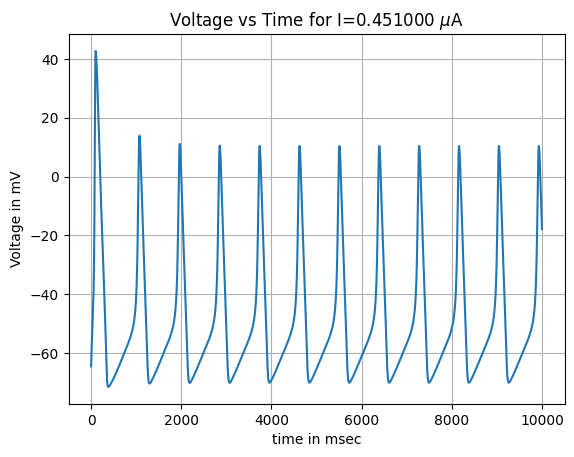

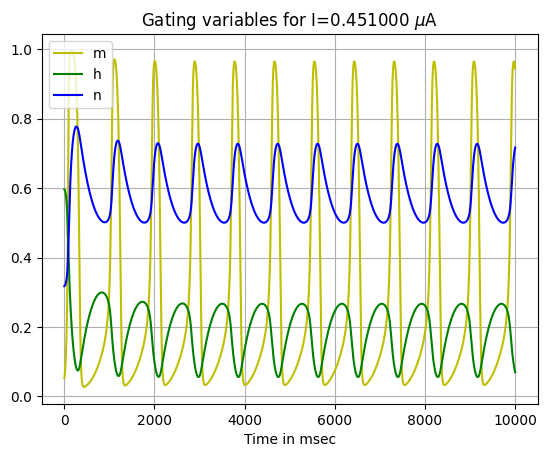

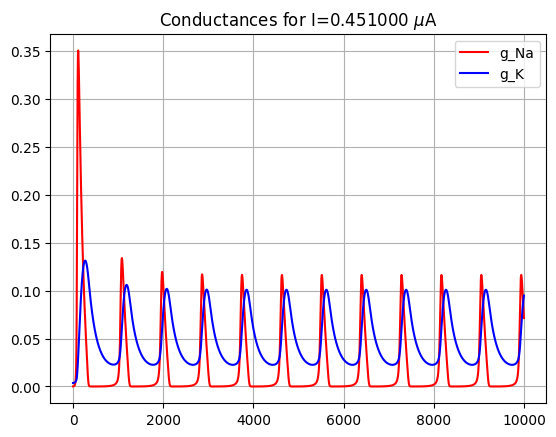

In [ ]:
from neuron import h
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc') #standard run tools

ImpCur = 0.451 # change input current here
g_K_max = 0.36 # max conductance of K channel
V_K = -77 # voltage of K channel
g_Na_max = 1.20 # max conductance of Na channel
V_Na = 50 # voltage of Na channel
g_l = 0.003 # conductance of combined gates
V_l = -54.387 # voltage of combined channel
cm = 0.01 

dt = 0.01 # 0.01 ms
niter = 10000
t = h.Vector()
t.indgen(niter)
t.mul(dt)

I_app = h.Vector()
I_app.resize(niter)
I_app.fill(ImpCur)

V = -64.9964 # base voltage
m = 0.0530
h2 = 0.5960
n = 0.3177

# create vectors to store the values
g_Na_hist = h.Vector()
g_Na_hist.resize(niter)
g_K_hist = h.Vector()
g_K_hist.resize(niter)
V_hist = h.Vector()
V_hist.resize(niter)
m_hist = h.Vector()
m_hist.resize(niter)
h_hist = h.Vector()
h_hist.resize(niter)
n_hist = h.Vector()
n_hist.resize(niter)

for i in range(niter):
    g_Na_hist[i] = g_Na_max * (m**3) * h2
    g_K_hist[i] = g_K_max * (n**4)
    g_total = g_Na_hist[i] + g_K_hist[i] + g_l
    V_inf = ((g_Na_hist[i]*V_Na + g_K_hist[i]*V_K + g_l*V_l) + I_app[i]) / g_total
    tau_v = cm / g_total
    V = V_inf + (V - V_inf) * np.exp(-dt / tau_v)
    alpha_m = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta_m = 4 * np.exp(-0.0556 * (V + 65))
    alpha_n = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta_n = 0.125 * np.exp(-(V + 65) / 80)
    alpha_h = 0.07 * np.exp(-0.05 * (V + 65))
    beta_h = 1 / (1 + np.exp(-0.1 * (V + 35)))
    tau_m = 1 / (alpha_m + beta_m)
    tau_h = 1 / (alpha_h + beta_h)
    tau_n = 1 / (alpha_n + beta_n)
    m_inf = alpha_m * tau_m
    h_inf = alpha_h * tau_h
    n_inf = alpha_n * tau_n
    m = m_inf + (m - m_inf) * np.exp(-dt / tau_m)
    h2 = h_inf + (h2 - h_inf) * np.exp(-dt / tau_h)
    n = n_inf + (n - n_inf) * np.exp(-dt / tau_n)
    V_hist.x[i] = V
    m_hist.x[i] = m 
    h_hist.x[i] = h2 
    n_hist.x[i] = n

def plot_V_vs_t(V_hist, I_ext):
    plt.plot(V_hist)
    plt.grid()
    plt.title('Voltage vs Time for I=%f $\mu$A' % I_ext)
    plt.xlabel('time in msec')
    plt.ylabel('Voltage in mV')
    plt.show()

def plot_gating_variables(m, h, n, I_ext):
    plt.plot(m, 'y', label='m')
    plt.plot(h, 'g', label='h')
    plt.plot(n, 'b', label='n')
    plt.xlabel('Time in msec')
    plt.title('Gating variables for I=%f $\mu$A' % I_ext)
    plt.grid()
    plt.legend()
    plt.show()
  
def plot_gating_variables(m, h, n, I_ext):
    plt.plot(m, 'y', label='m')
    plt.plot(h, 'g', label='h')
    plt.plot(n, 'b', label='n')
    plt.xlabel('Time in msec')
    plt.title('Gating variables for I=%f $\mu$A' % I_ext)
    plt.grid()
    plt.legend()
    plt.show()

def plot_conductances(g_Na, g_K, I_ext):
    plt.plot(g_Na, 'r', label='g_Na')
    plt.plot(g_K, 'b', label='g_K')
    plt.title('Conductances for I=%f $\mu$A' % I_ext)
    plt.legend()
    plt.grid()
    plt.show()

plot_V_vs_t(V_hist, ImpCur)
plot_gating_variables(m_hist, h_hist, n_hist, ImpCur)
plot_conductances(g_Na_hist, g_K_hist, ImpCur)

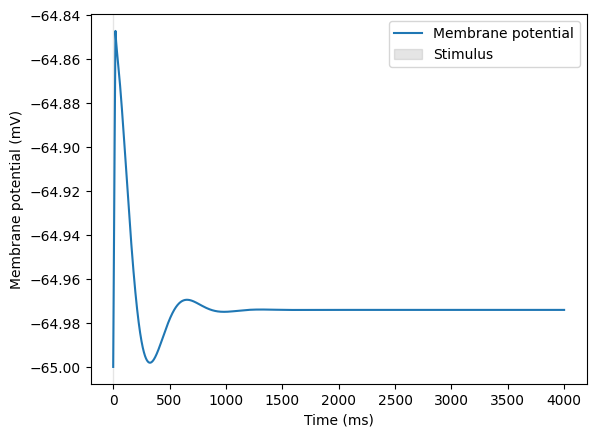

In [ ]:
from neuron import h, gui
import matplotlib.pyplot as plt

# create a single-compartment neuron
soma = h.Section(name='soma')
soma.insert('hh')  # insert the Hodgkin-Huxley mechanism

# set the simulation parameters
h.dt = 0.025  # time step
h.tstop = 100  # simulation duration

# create a current clamp stimulus
stim = h.IClamp(soma(0.5))
stim.delay = 0  # delay before the stimulus starts
stim.dur = 0.5  # duration of the stimulus
stim.amp = 0.5  # amplitude of the stimulus

# record the membrane potential
v_rec = h.Vector()
v_rec.record(soma(0.5)._ref_v)

# run the simulation
h.finitialize(0)  # set the initial membrane potential
h.run()

# plot the results
fig, ax = plt.subplots()
ax.plot(v_rec, label='Membrane potential')
ax.axvspan(stim.delay, stim.delay+stim.dur, color='gray', alpha=0.2, label='Stimulus')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)')
ax.legend()
plt.show()


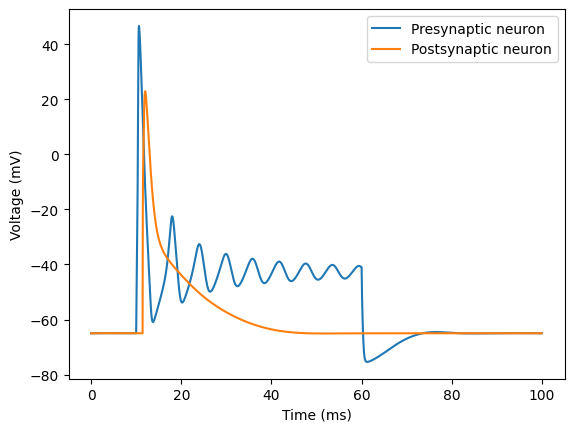

In [ ]:
from neuron import h, gui

# Define simulation parameters
tstop = 100   # simulation time in ms
dt = 0.01     # time step size in ms

# Create presynaptic neuron
pre = h.Section(name='pre')
pre.L = 10  # length of the section in um
pre.diam = 10  # diameter of the section in um
pre.insert('hh')  # insert Hodgkin-Huxley mechanism

# Set presynaptic current clamp stimulus
stim = h.IClamp(pre(0.5))
stim.delay = 10   # delay before stimulus starts
stim.dur = 50     # duration of the stimulus in ms
stim.amp = 0.5    # amplitude of the stimulus in nA

# Create postsynaptic neuron
post = h.Section(name='post')
post.L = 10  # length of the section in um
post.diam = 10  # diameter of the section in um
post.insert('hh')  # insert Hodgkin-Huxley mechanism

# Connect presynaptic and postsynaptic neurons with a synapse
syn = h.ExpSyn(post(0.5))
syn.e = 0   # reversal potential of the synapse in mV
syn.tau = 5  # time constant of the synapse in ms

# Connect presynaptic and postsynaptic neurons
nc = h.NetCon(pre(0.5)._ref_v, syn, sec=pre)
nc.weight[0] = 0.1  # synaptic weight in uS

# Record variables for plotting
time = h.Vector().record(h._ref_t)
v_pre = h.Vector().record(pre(0.5)._ref_v)
v_post = h.Vector().record(post(0.5)._ref_v)

# Run the simulation
h.finitialize(-65)
h.continuerun(tstop)

# Plot results
import matplotlib.pyplot as plt
plt.plot(time, v_pre, label='Presynaptic neuron')
plt.plot(time, v_post, label='Postsynaptic neuron')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()


In [ ]:
from brian2 import *
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
start_scope()

In [ ]:

area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
     

In [ ]:
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''

In [ ]:
Group = NeuronGroup(1, eqs_HH,threshold='v > -50*mV',refractory='v > -40*mV',method='exponential_euler')

WARNING    'm' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.9443686649345382. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'n' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.7169689492865599. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


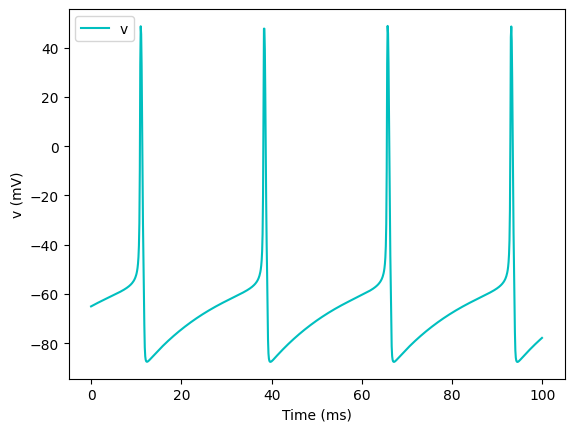

In [ ]:

statemon_v = StateMonitor(Group, 'v', record=True)
Group.v = El
Group.I = 200*pA
run(100*ms)
plot(statemon_v.t/ms, statemon_v.v[0]/mV, '-c',label='v')
xlabel('Time (ms)')
ylabel('v (mV)');
legend(loc='best',fontsize=10)

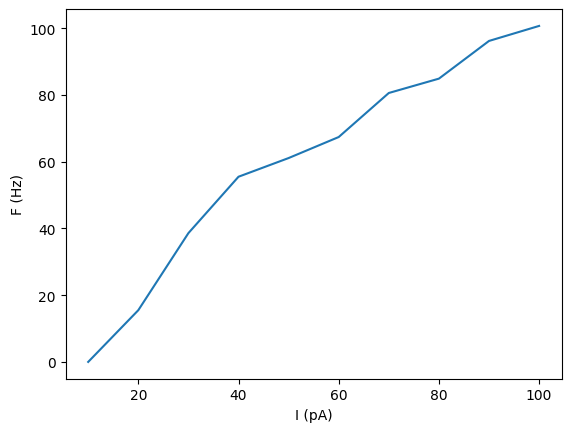

In [ ]:

I_list=[]
t_list=[]
for i in numpy.linspace(1,10,10,10):
  spikemon = SpikeMonitor(Group)
  Group.I=(10*i)*pA
  time=10000*ms
  run(time)
  I_list.append((10*i)*pA)
  t_list.append(len(spikemon.t))
plot(I_list/pA,t_list/(time))
xlabel('I (pA)')
ylabel('F (Hz)');

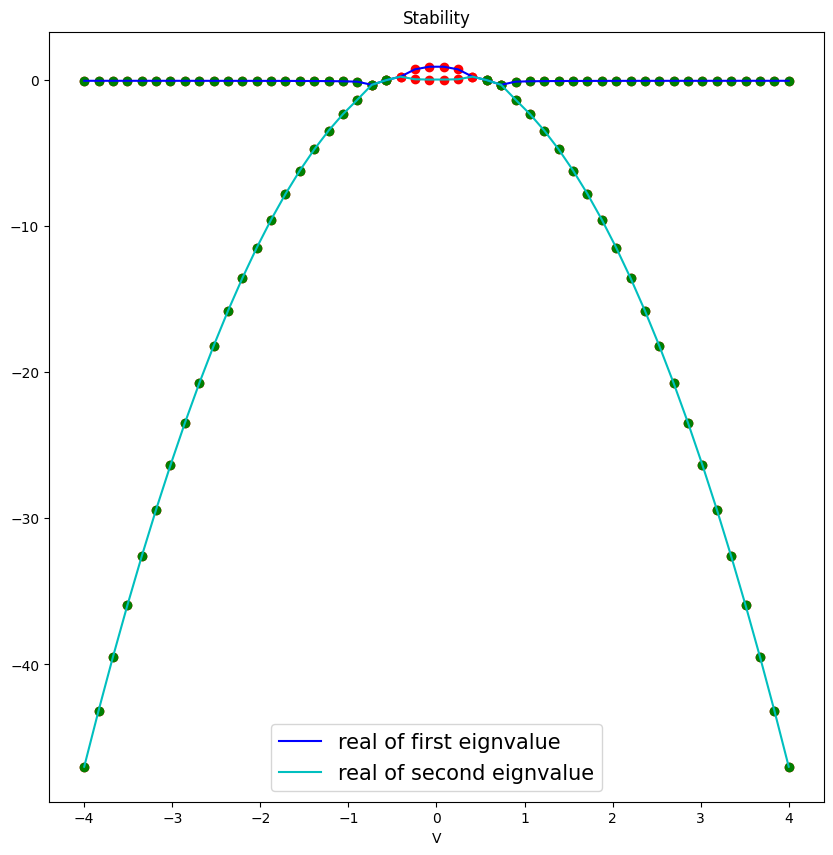

In [ ]:
v_list=[]
S_1_list=[]
S_2_list=[]
fig,ax = subplots(figsize=[10,10])
for v in np.linspace(-4,4,50):
  a=1
  b = -0.936+3*v**2
  c = 0.192*v**2+0.016
  Sol_1 = (-1*b + np.sqrt(b**2 - 4*a*c))/(2*a) if (b**2-4*a*c)>0 else complex(-1*b,np.sqrt(-1*((b**2-4*a*c))))/(2*a)
  Sol_2 = (-1*b - np.sqrt(b**2 - 4*a*c))/(2*a) if (b**2-4*a*c)>0 else complex(-1*b,-1*np.sqrt(-1*((b**2-4*a*c))))/(2*a)
  v_list.append(v)
  S_1_list.append(np.real(Sol_1))
  S_2_list.append(np.real(Sol_2))
ax.plot(v_list,S_1_list,'-b',label='real of first eignvalue')
ax.plot(v_list,S_2_list,'-c',label='real of second eignvalue')
ax.legend(loc='best',fontsize=15)
ax.set_xlabel('V')
ax.set_title('Stability')


for v in np.linspace(-4,4,50):
  a=1
  b = -0.936+3*v**2
  c = 0.192*v**2+0.016
  Sol_1 = (-1*b + np.sqrt(b**2 - 4*a*c))/(2*a) if (b**2-4*a*c)>0 else complex(-1*b,np.sqrt(-1*((b**2-4*a*c))))/(2*a)
  Sol_2 = (-1*b - np.sqrt(b**2 - 4*a*c))/(2*a) if (b**2-4*a*c)>0 else complex(-1*b,-1*np.sqrt(-1*((b**2-4*a*c))))/(2*a)
  ax.scatter(v,np.real(Sol_1),c='r')
  ax.scatter(v,np.real(Sol_2),c='r')
  if np.real(Sol_1)<0 and np.real(Sol_2)<0:
    ax.scatter(v,np.real(Sol_1),c='g')
    ax.scatter(v,np.real(Sol_2),c='g')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import odeint

# Set random seed (for reproducibility)
np.random.seed(1000)

# Start and end time (in milliseconds)
tmin = 0.0
tmax = 50.0

# Average potassium channel conductance per unit area (mS/cm^2)
gK = 36.0

# Average sodoum channel conductance per unit area (mS/cm^2)
gNa = 120.0

# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3

# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0

# Potassium potential (mV)
VK = -12.0

# Sodium potential (mV)
VNa = 115.0

# Leak potential (mV)
Vl = 10.613

# Time values
T = np.linspace(tmin, tmax, 10000)

# Potassium ion-channel rate functions

def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

# Sodium ion-channel rate functions

def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)

def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)
  
# n, m, and h steady-state values

def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))
  
# Input stimulus
def Id(t):
    if 0.0 < t < 1.0:
        return 150.0
    elif 10.0 < t < 11.0:
        return 50.0
    return 0.0
  
# Compute derivatives
def compute_derivatives(y, t0):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy
  
# State (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])

# Solve ODE system
# Vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])
Vy = odeint(compute_derivatives, Y, T)

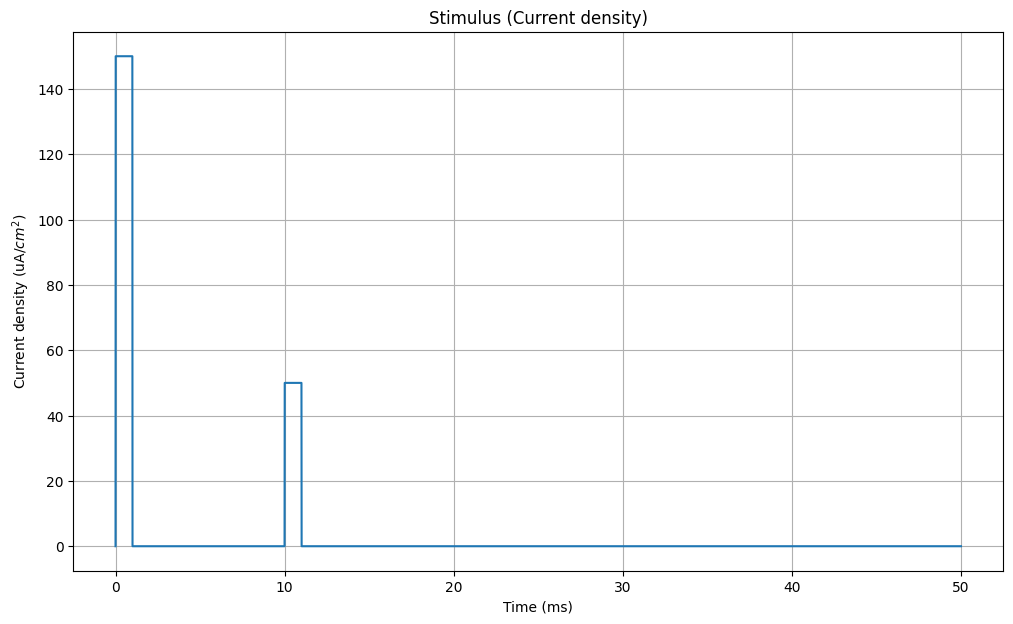

In [ ]:
# Input stimulus
Idv = [Id(t) for t in T]

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, Idv)
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Current density (uA/$cm^2$)')
ax.set_title('Stimulus (Current density)')
plt.grid()